In [ ]:
#### IAU Project Phase 2 - Data Preprocessing
#### Andrej Horváth / Adam Partl
#### Share of work : 50% / 50%

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, PolynomialFeatures, QuantileTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, SelectFromModel, RFE, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
connections_df = pd.read_csv('data/connections.csv',delimiter='\t', on_bad_lines='skip')
processes_df = pd.read_csv('data/processes.csv',delimiter='\t', on_bad_lines='skip')

In [ ]:
connections_df.head(), processes_df.head(), connections_df.columns, processes_df.columns


In [ ]:
merged_df = pd.merge(connections_df, processes_df, on=['ts', 'imei'], how='inner')

In [ ]:
merged_df.head()

In [ ]:
differences = merged_df[merged_df['mwra_x'] != merged_df['mwra_y']]
differences

In [ ]:
merged_df = merged_df.drop(columns=['mwra_y']).rename(columns={'mwra_x': 'mwra'})

In [ ]:
X = merged_df.drop(columns=['mwra', 'ts', 'imei'])
y = merged_df['mwra']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

### Now that we have successfully prepared the data and split them into training and testing sets, we can proceed to find the best methods for feature selection, scaling and transforming that are going to eb used then in the final pipeline.
### Due to us testing multiple combinations to find the best one, the next code block has a runtime of about 5 minutes

In [19]:
# Define which columns are numerical and which are categorical
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Categorical pipeline: imputation, encoding
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),    # Handle missing values
    ('encoder', OneHotEncoder(handle_unknown='ignore'))      # Encoding technique
])

# Define pipelines with multiple transformations for numerical features
num_pipeline_alternatives = {
    'standard+power': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('power', PowerTransformer())
    ]),
    'minmax+polynomial': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler()),
        ('poly', PolynomialFeatures(degree=2))
    ]),
    'robust+quantile': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('quantile', QuantileTransformer())
    ])
}

# Feature selection options
feature_selection_alternatives = {
    'f_classif': SelectKBest(score_func=f_classif, k=10),
    'mutual_info': SelectKBest(score_func=mutual_info_classif, k=10),
    'from_model_rf': SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42)),
    'rfe_lr': RFE(estimator=LogisticRegression(max_iter=200), n_features_to_select=10)
}

# Testing different combinations of scaling, transformations, and feature selection
for num_pipeline_name, num_pipeline in num_pipeline_alternatives.items():
    for fs_name, feature_selection in feature_selection_alternatives.items():
        try:
            # Define the full pipeline
            full_pipeline = Pipeline([
                ('preprocessor', ColumnTransformer([
                    ('num', num_pipeline, num_features),
                    ('cat', cat_pipeline, cat_features)
                ])),
                ('feature_selection', feature_selection),
                ('classifier', LogisticRegression(max_iter=200))
            ])

            # Fit and evaluate the pipeline
            full_pipeline.fit(X_train, y_train)
            train_score = full_pipeline.score(X_train, y_train)
            test_score = full_pipeline.score(X_test, y_test)
            print(f"Pipeline with {num_pipeline_name} and {fs_name} selection: Train Score = {train_score}, Test Score = {test_score}")

        except Exception as e:
            print(f"Error with pipeline {num_pipeline_name} and {fs_name} selection: {e}")

Pipeline with standard+power and f_classif selection: Train Score = 0.9144198850295523, Test Score = 0.9141839378238342
Pipeline with standard+power and mutual_info selection: Train Score = 0.9144198850295523, Test Score = 0.9141839378238342
Pipeline with standard+power and from_model_rf selection: Train Score = 0.9041373168164522, Test Score = 0.9060880829015544
Pipeline with standard+power and rfe_lr selection: Train Score = 0.9155533964861144, Test Score = 0.9145077720207254


C:\Users\partl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\partl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Pipeline with minmax+polynomial and f_classif selection: Train Score = 0.9046231074406931, Test Score = 0.9018782383419689
Pipeline with minmax+polynomial and mutual_info selection: Train Score = 0.885677273095296, Test Score = 0.8792098445595855
Pipeline with minmax+polynomial and from_model_rf selection: Train Score = 0.918872965751761, Test Score = 0.9177461139896373
Pipeline with minmax+polynomial and rfe_lr selection: Train Score = 0.9176584891911587, Test Score = 0.9161269430051814
Pipeline with robust+quantile and f_classif selection: Train Score = 0.9100477694113837, Test Score = 0.9096502590673575
Pipeline with robust+quantile and mutual_info selection: Train Score = 0.9105335600356247, Test Score = 0.9096502590673575
Pipeline with robust+quantile and from_model_rf selection: Train Score = 0.9021941543194884, Test Score = 0.8996113989637305
Pipeline with robust+quantile and rfe_lr selection: Train Score = 0.9102906647235042, Test Score = 0.9096502590673575


Based on the results of this testing, we can see that the best performing combination for the pipeline is to use **Simple Imputer** with **Min Max Scaler** and **Polynomial Transformer** . Futhermore the feature selection method that seems to be the best for the setting of this pipeline is **Random Forest**
Next we will proceed with some fine-tuning to try to get even better accuracy and base the final pipeline on that.

### Final Pipeline

In [21]:
# Define which columns are numerical and which are categorical
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2)),
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(handle_unknown='ignore')),    
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Create a full pipeline with the preprocessor and feature selection
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),  # Feature selection
    ('classifier', LogisticRegression(max_iter=200))
])

# Fit the pipeline to the training data
full_pipeline.fit(X_train, y_train)

# Evaluate the model
train_score = full_pipeline.score(X_train, y_train)
test_predictions = full_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)

# Save the pipeline
pipeline_filename = 'pipeline.pkl'
joblib.dump(full_pipeline, pipeline_filename)

train_score, test_accuracy, pipeline_filename

(0.918872965751761, 0.9177461139896373, 'pipeline.pkl')

In [22]:
from sklearn.model_selection import cross_val_score

# Run cross-validation on the training data
cv_scores = cross_val_score(full_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Mean Accuracy:", cv_scores.mean())

Cross-Validation Mean Accuracy: 0.9174963995300957


In [23]:
from sklearn.metrics import classification_report

train_predictions = full_pipeline.predict(X_train)
print("Training Classification Report:\n", classification_report(y_train, train_predictions))

Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.85      0.89      4599
         1.0       0.92      0.96      0.94      7752

    accuracy                           0.92     12351
   macro avg       0.92      0.91      0.91     12351
weighted avg       0.92      0.92      0.92     12351


In [24]:
test_predictions = full_pipeline.predict(X_test)
print("Test Classification Report:\n", classification_report(y_test, test_predictions))

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.84      0.88      1147
         1.0       0.91      0.96      0.94      1941

    accuracy                           0.92      3088
   macro avg       0.92      0.90      0.91      3088
weighted avg       0.92      0.92      0.92      3088


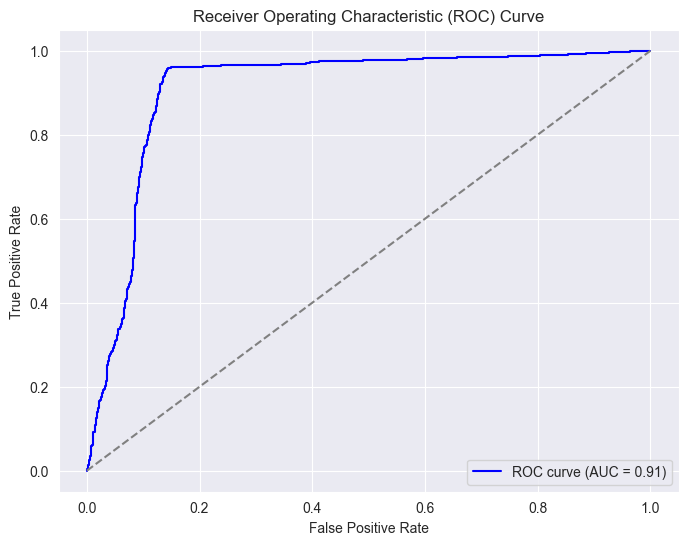

In [31]:
y_test_proba = full_pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc_score = roc_auc_score(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [28]:
feature_selector = full_pipeline.named_steps['feature_selection']
selected_model = feature_selector.estimator_  # This is the RandomForestClassifier

# Extract feature importances from the RandomForest model
importances = selected_model.feature_importances_

# Get feature names after preprocessing (i.e., after encoding and transformation)
preprocessed_features = full_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a sorted list of features with their importances
feature_importances = sorted(zip(preprocessed_features, importances), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 most important features:")
for feature, importance in feature_importances:
    print(f"{feature}: {importance}")

Top 10 most important features:
num__c.android.gm p.android.packageinstaller: 0.03571765432602322
num__c.android.gm: 0.03423105638043379
num__c.android.chrome c.updateassist: 0.03211153797190989
num__c.android.gm c.android.chrome: 0.031371614918096036
num__c.updateassist p.android.gm: 0.029539786873566357
num__c.android.youtube^2: 0.029338956794385078
num__c.android.gm^2: 0.024038273557632918
num__c.updateassist p.android.externalstorage: 0.019356334927093308
num__c.android.gm c.updateassist: 0.01704147736061731
num__c.android.youtube p.android.settings: 0.01674670754857222
